<a href="https://colab.research.google.com/github/provincit/colab_public/blob/main/fetch_20newsgroups_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'] 

data subset:
(2379,) shape of train data
(1584,) shape of test data 

<<Pipeline>> 

f1_score 0.9621212121212122 

sci.med predictions:
370 correct predictions
1 misclassified as rec.autos
7 misclassified as sci.space

***PREDICTIONS***:
sci.space
rec.autos
sci.med


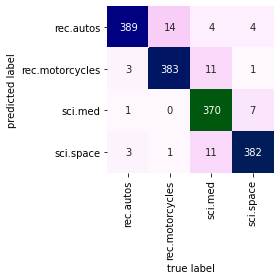

In [2]:
def predict_category(s, m, t):
 pred = m.predict([s])
 return t[pred[0]]

br = '\n'
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')
print (train.target_names, br)
categories = ['rec.autos', 'rec.motorcycles', 'sci.space', 'sci.med']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)
print ('data subset:')
print (train.target.shape, 'shape of train data')
print (test.target.shape, 'shape of test data', br)
targets = train.target_names
mnb_clf = make_pipeline(TfidfVectorizer(), MultinomialNB())
print ('<<' + mnb_clf.__class__.__name__ + '>>', br)
mnb_clf.fit(train.data, train.target)
labels = mnb_clf.predict(test.data)
f1 = f1_score(test.target, labels, average='micro')
print ('f1_score', f1, br)
cm = confusion_matrix(test.target, labels)
plt.figure('confusion matrix')
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cmap='gist_ncar_r',
xticklabels=train.target_names, yticklabels=train.target_names, cbar=False)
print ('sci.med predictions:')
print (cm.T[2][2], 'correct predictions')
print (cm.T[2][0], 'misclassified as rec.autos')
print (cm.T[2][3], 'misclassified as sci.space')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.tight_layout()
print ('\n***PREDICTIONS***:')
y_pred = predict_category('payload on the mars rover', mnb_clf, targets)

print (y_pred)
y_pred = predict_category('car broke down on the highway', mnb_clf,
targets)
print (y_pred)
y_pred = predict_category('dad died of cancer', mnb_clf, targets)
print (y_pred)

Tuning fetch_20newsgroups with a pipelined model

In [3]:
import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [4]:
def get_cross(model, data, target, groups=10):
 return cross_val_score(model, data, target, cv=groups)

In [7]:
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')
categories = ['rec.autos', 'rec.motorcycles', 'sci.space', 'sci.med']
train = fetch_20newsgroups(subset='train', categories=categories,
remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', categories=categories,
remove=('headers', 'footers', 'quotes'))
targets = train.target_names
mnb = MultinomialNB()
tf = TfidfVectorizer()
print (mnb, br)
print (tf, br)
pipe = make_pipeline(tf, mnb)
pipe.fit(train.data, train.target)
labels = pipe.predict(test.data)
f1 = f1_score(test.target, labels, average='micro')
print ('f1_score', f1, br)
print (pipe.get_params().keys(), br)
param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
'tfidfvectorizer__use_idf': [True, False],
'multinomialnb__alpha': [1e-2, 1e-3],
'multinomialnb__fit_prior': [True, False]}
start = time.time()

rand = RandomizedSearchCV(pipe, param_grid, cv=5, n_jobs = -1, random_state=0, n_iter=16, verbose=2)
print('RandomizedSearchCV tuning time:')
rand.fit(train.data, train.target)
end_time = time.time()
print(end_time-start)
bp = rand.best_params_
print ()
print ('best parameters:')
print (bp, br)
rbs = rand.best_score_
mnb = MultinomialNB(alpha=0.01)
tf = TfidfVectorizer(ngram_range=(1, 1), use_idf=False)
pipe = make_pipeline(tf, mnb)
pipe.fit(train.data, train.target)
labels = pipe.predict(test.data)
f1 = f1_score(test.target, labels, average='micro')
print ('f1_score', f1, br)


print ('best parameters:')
print (bp, br)
start = time.time()
scores = get_cross(pipe, train.data, train.target)
end_time = time.time()
print(end_time-start)
print("Cross val")
print (np.mean(scores))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None) 

f1_score 0.8440656565656567 

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'multinomialnb', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   57.3s finished


57.68977117538452

best parameters:
{'tfidfvectorizer__use_idf': False, 'tfidfvectorizer__ngram_range': (1, 1), 'multinomialnb__fit_prior': False, 'multinomialnb__alpha': 0.01} 

f1_score 0.8611111111111112 

best parameters:
{'tfidfvectorizer__use_idf': False, 'tfidfvectorizer__ngram_range': (1, 1), 'multinomialnb__fit_prior': False, 'multinomialnb__alpha': 0.01} 

3.4414775371551514
Cross val
0.874736730135092
